### Import Necessary Libraries
This section imports the essential libraries required for building, training, and evaluating a neural network:

- **PyTorch (`torch`)**: For creating and training deep learning models.
- **NumPy (`numpy`)**: For numerical operations with arrays and tensors.
- **TorchVision**: For accessing datasets and image preprocessing tools.
- **Matplotlib**: To visualize data and model performance.
- **Scikit-learn Metrics**: To evaluate model performance with metrics like accuracy and F1-score.

### Device Configuration
- The `device` is set to use a GPU if available for faster training; otherwise, it defaults to the CPU.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Data Preparation and Transformation

#### 1. **Data Transformations**
- **`transform_train`**: Applies data augmentation to the training dataset:
  - Random horizontal flip to improve robustness.
  - Random rotation (up to 20 degrees) for variability.
  - Random crop and resize to standardize input size.
  - Converts images to tensors and normalizes pixel values.
- **`transform_test`**: Normalizes the test/validation datasets without augmentation to ensure consistent evaluation.

#### 2. **Dataset Loading**
- **FashionMNIST Dataset**:
  - Downloads the FashionMNIST dataset with the specified transformations.
  - Training dataset is split into:
    - **Training set (75%)**: Used for training the model.
    - **Validation set (25%)**: Used to validate the model during training.

#### 3. **Data Loaders**
- Data loaders are created for each dataset (training, validation, and test) with a batch size of 100.
  - Training data is shuffled for better model generalization.
  - Validation and test sets are not shuffled to maintain consistency.

#### 4. **Dataset Sizes**
- The sizes of the training, validation, and test datasets are calculated and displayed.

### Output
Prints the number of samples in the training, validation, and test datasets:
```python
dataset_sizes = {'train': ..., 'val': ..., 'test': ...}


In [ ]:
# Data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(20),      # Randomly rotate images by up to 10 degrees
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize for test/validation sets
])

# Download the FashionMNIST dataset with the appropriate transforms
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform=transform_train, download=True)
fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform=transform_test, download=True)

# Split the training dataset into training and validation sets
train_size = int(np.floor(0.75 * len(fashion_mnist_train)))
val_size = int(np.ceil(0.25 * len(fashion_mnist_train)))
fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [train_size, val_size])

# Set batch size
batch_size = 100

# Create data loaders
dataloaders = {
    'train': DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True),  # Shuffle training set
    'val': DataLoader(fashion_mnist_val, batch_size=batch_size, shuffle=False),     # No need to shuffle validation set
    'test': DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)    # No need to shuffle test set
}

# Get dataset sizes
dataset_sizes = {
    'train': len(fashion_mnist_train),
    'val': len(fashion_mnist_val),
    'test': len(fashion_mnist_test)
}

print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


### Visualizing FashionMNIST Digits by Class

#### **Function: `view_fashionmnist(label, count=1)`**
This function plots the ground truth images of a specified class label from the FashionMNIST test dataset.

#### **Key Steps**
1. **Loop Through Test Data**:
   - Iterates over batches of inputs and labels in the test dataset using the `dataloaders["test"]`.

2. **Filter by Label**:
   - Only images corresponding to the specified `label` are selected for visualization.

3. **Plot Images**:
   - Converts the selected tensor images to NumPy arrays and reshapes them into 28x28 pixel format.
   - Uses Matplotlib to display the images in grayscale (`cmap='gray'`).

4. **Limits the Number of Plots**:
   - The `count` parameter controls how many images of the specified class are displayed.
   - Stops once the specified number of images is plotted.


In [ ]:
# plot a digit ground truth and autoencoding
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

### Viewing FashionMNIST Class: Bags

#### **Code: `view_fashionmnist(8, 6)`**
- **Purpose**: Displays 6 images of class `8` (Bags) from the FashionMNIST test dataset.
- **How It Works**:
  - Calls the `view_fashionmnist` function with:
    - `label=8`: Filters for the class representing Bags in the dataset.
    - `count=6`: Specifies that 6 images should be displayed.

#### **Output**
A Matplotlib figure displaying 6 grayscale images of Bags from the FashionMNIST test dataset.


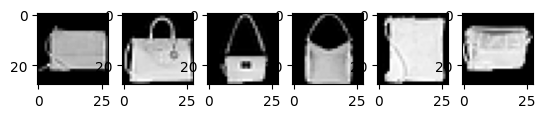

In [ ]:
# View 6 bags
view_fashionmnist(8, 6)

### Viewing FashionMNIST Class: Sneaker

#### **Code: `view_fashionmnist(7, 1)`**
- **Purpose**: Displays 1 image of class `7` (Sneakers) from the FashionMNIST test dataset.
- **How It Works**:
  - Calls the `view_fashionmnist` function with:
    - `label=7`: Filters for the class representing Sneakers in the dataset.
    - `count=1`: Specifies that only 1 image should be displayed.

#### **Output**
A Matplotlib figure displaying a single grayscale image of a Sneaker from the FashionMNIST test dataset.


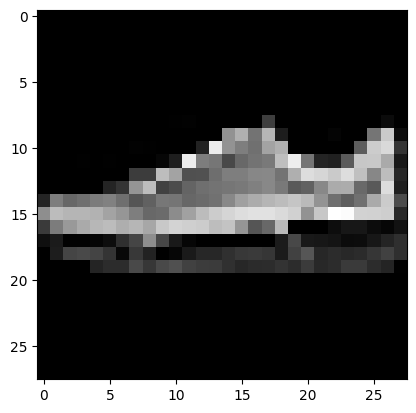

In [ ]:
# View 1 sneaker
view_fashionmnist(7, 1)

### Defining a CNN Classifier with Dropout Layers

#### **Class: `CNNClassifier`**
This class defines a Convolutional Neural Network (CNN) for image classification, designed to classify FashionMNIST data into 10 classes (e.g., shirts, shoes, bags).

#### **Key Features**
1. **Initialization (`__init__`)**:
   - The network architecture is built using `nn.Sequential`, providing a clean and modular pipeline.

2. **Architecture**:
   - **Convolutional Layer**:
     - `in_channels=1`: For grayscale images (single channel).
     - `out_channels=8`: Produces 8 feature maps.
     - `kernel_size=3`: 3x3 filters with `stride=1` and `padding=1`.
     - Followed by `ReLU` activation.
   - **Pooling Layer**:
     - `MaxPool2d` reduces spatial dimensions (downsampling).
   - **Dropout**:
     - Adds regularization to prevent overfitting:
       - `Dropout(0.25)`: After the pooling layer.
       - `Dropout(0.5)`: Before fully connected layers.
   - **Fully Connected Layers**:
     - First Layer:
       - Input size: `8 * 14 * 14` (flattened feature maps).
       - Output size: `128` neurons with `ReLU` activation.
     - Output Layer:
       - Maps the final 128 neurons to 10 classes for classification.

3. **Forward Pass (`forward`)**:
   - Takes an input tensor `x` and passes it through the pipeline to generate predictions.




In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        # Your pipeline with Dropout layers added
        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Adding a dropout layer after pooling with 25% dropout rate

            nn.Flatten(),
            nn.Linear(8 * 14 * 14, 128),  # Increased the number of neurons in this layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Adding a dropout layer before the final fully connected layers with 50% dropout rate

            nn.Linear(128, 10)  # Output layer for classification
        )

    def forward(self, x):
        return self.pipeline(x)
        return self.pipeline(x)

### Model Initialization and Configuration

#### **Learning Rate**
- **`learning_rate = 0.0005`**:
  - The learning rate controls how much the model weights are updated during each optimization step.
  - Reduced from `0.001` to make the training process more stable and prevent overshooting the optimal solution.

#### **Number of Epochs**
- **`num_epochs = 10`**:
  - Specifies the number of times the model will pass through the entire training dataset.

#### **Model Initialization**
- **`model = CNNClassifier().to(device)`**:
  - Initializes the `CNNClassifier` model and moves it to the specified device (`GPU` if available, otherwise `CPU`).

#### **Model Summary**
- **`print(model)`**:
  - Displays the architecture of the CNN model, showing each layer and its configuration.



In [ ]:
learning_rate = 0.0005  # Reduced from 0.001
num_epochs = 10

model = CNNClassifier().to(device)
print(model)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1568, out_features=128, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Training the Classification Model

#### **Function: `train_classification_model`**
This function trains a neural network model for a specified number of epochs, evaluates its performance on validation and test sets, and saves the best-performing model based on validation accuracy.

#### **Parameters**
- **`model`**: The neural network to be trained (e.g., `CNNClassifier`).
- **`dataloaders`**: Dictionary containing data loaders for training, validation, and test datasets.
- **`dataset_sizes`**: Dictionary with the sizes of training, validation, and test datasets.
- **`criterion`**: Loss function to evaluate model performance.
- **`optimizer`**: Optimization algorithm to update model weights (e.g., SGD, Adam).
- **`scheduler`**: Learning rate scheduler to adjust the learning rate dynamically during training.
- **`num_epochs`**: Number of epochs for training (default: 25).

1. **Initialization**:
   - Records the start time and creates variables to track the best model weights and accuracy.

2. **Training and Evaluation**:
   - Iterates through each epoch, alternating between training, validation, and test phases:
     - **Training Phase**:
       - Sets the model to training mode (`model.train()`).
       - Performs forward and backward passes to calculate gradients and update weights.
     - **Validation/Test Phase**:
       - Sets the model to evaluation mode (`model.eval()`).
       - Computes predictions and evaluates performance without updating weights.
   - Tracks loss and accuracy for each phase.

3. **Metrics Tracking**:
   - Stores loss and accuracy for each phase across epochs.
   - Updates the best model weights based on validation accuracy.

4. **Best Model Selection**:
   - After training completes, restores the model's weights to those achieving the best validation accuracy.

5. **Summary**:
   - Prints the total training time and best validation accuracy, along with the epoch where it was achieved.

#### **Return Values**
- **`model`**: The trained model with the best weights based on validation accuracy.
- **`training_curves`**: A dictionary containing the loss and accuracy for each phase over all epochs.


In [ ]:
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

### Setting Up Loss, Optimizer, and Scheduler

#### **Loss Function**
- **`criterion = nn.CrossEntropyLoss()`**:
  - Used for classification tasks.
  - Combines `LogSoftmax` and `NLLLoss` to measure the difference between the predicted probabilities and the actual class labels.

#### **Optimizer**
- **`optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)`**:
  - Optimizes model parameters using the Adam algorithm, known for efficient training and convergence.
  - **Learning rate**: Controls the size of updates during training (`learning_rate = 0.0005`).
  - **Weight decay**: Adds L2 regularization to prevent overfitting by penalizing large weights (`weight_decay = 1e-4`).

#### **Learning Rate Scheduler**
- **`scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)`**:
  - Gradually decreases the learning rate by multiplying it with `gamma=0.95` after each epoch.
  - Helps the model converge by taking smaller steps as training progresses.

#### **Training the Model**
- **`train_classification_model(...)`**:
  - Trains the model using the specified dataloaders, loss function, optimizer, and scheduler.
  - Tracks training and validation loss and accuracy for visualization.



In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
# Modify the optimizer to include weight decay (L2 regularization)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
# Train the model. We also will store the results of training to visualize
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 1.0732 Acc: 0.6144
val   Loss: 0.7343 Acc: 0.7299
test  Loss: 0.6626 Acc: 0.7539

Epoch 2/10
----------
train Loss: 0.7911 Acc: 0.7089
val   Loss: 0.6487 Acc: 0.7577
test  Loss: 0.5854 Acc: 0.7822

Epoch 3/10
----------
train Loss: 0.7251 Acc: 0.7321
val   Loss: 0.6011 Acc: 0.7751
test  Loss: 0.5448 Acc: 0.7955

Epoch 4/10
----------
train Loss: 0.6889 Acc: 0.7458
val   Loss: 0.5767 Acc: 0.7833
test  Loss: 0.5107 Acc: 0.8103

Epoch 5/10
----------
train Loss: 0.6668 Acc: 0.7538
val   Loss: 0.5590 Acc: 0.7899
test  Loss: 0.4908 Acc: 0.8198

Epoch 6/10
----------
train Loss: 0.6474 Acc: 0.7627
val   Loss: 0.5472 Acc: 0.7967
test  Loss: 0.4870 Acc: 0.8257

Epoch 7/10
----------
train Loss: 0.6323 Acc: 0.7664
val   Loss: 0.5308 Acc: 0.8009
test  Loss: 0.4629 Acc: 0.8288

Epoch 8/10
----------
train Loss: 0.6185 Acc: 0.7710
val   Loss: 0.5185 Acc: 0.8066
test  Loss: 0.4597 Acc: 0.8301

Epoch 9/10
----------
train Loss: 0.6052 Acc: 0.7761
val   Loss: 0.5014

### Utility Functions for Visualization and Evaluation

#### **1. Plot Training Curves**
- **`plot_training_curves(training_curves, phases, metrics)`**:
  - Visualizes the evolution of loss and accuracy for each phase (`train`, `val`, `test`) over epochs.
  - **Parameters**:
    - `training_curves`: Dictionary containing loss and accuracy values for each phase and epoch.
    - `phases`: List of phases to plot (default: `['train', 'val', 'test']`).
    - `metrics`: Metrics to plot (default: `['loss', 'acc']`).
  - **Key Steps**:
    - Extracts loss or accuracy values for each phase and plots them across epochs.


#### **2. Classify Predictions**
- **`classify_predictions(model, device, dataloader)`**:
  - Generates predictions and scores for all samples in a dataset.
  - **Parameters**:
    - `model`: The trained model.
    - `device`: Device for computation (`CPU` or `GPU`).
    - `dataloader`: DataLoader for the dataset to classify.
  - **Output**:
    - `all_preds`: Predicted class labels for the dataset.
    - `all_labels`: Ground truth labels for the dataset.
    - `all_scores`: Predicted confidence scores for the dataset.


#### **3. Plot Confusion Matrix**
- **`plot_cm(model, device, dataloaders, phase='test')`**:
  - Creates a confusion matrix to evaluate classification performance on a dataset.
  - **Parameters**:
    - `model`: The trained model.
    - `device`: Device for computation (`CPU` or `GPU`).
    - `dataloaders`: Dictionary of dataloaders.
    - `phase`: Dataset phase to evaluate (default: `'test'`).
  - **Key Steps**:
    - Calls `classify_predictions` to get predictions and labels.
    - Computes the confusion matrix and displays it with class labels.


#### **Output**
- **Training Curves**: Line plots showing loss and accuracy trends for each phase over epochs.
- **Predictions**: Predicted labels, ground truth labels, and confidence scores for a dataset.
- **Confusion Matrix**: Visualization of true vs. predicted labels, helping identify misclassifications.


In [ ]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

### Plotting Training Curves

#### **Code: `plot_training_curves(training_curves, phases=['train', 'val', 'test'])`**
- **Purpose**: Visualizes the training progress by plotting the loss and accuracy for the specified phases (`train`, `val`, `test`) over all epochs.

#### **Parameters**
- **`training_curves`**: A dictionary containing the loss and accuracy values for each phase (`train_loss`, `val_loss`, `test_loss`, `train_acc`, etc.).
- **`phases`**: A list of dataset phases to include in the plots (default: `['train', 'val', 'test']`).

#### **Key Features**
- **Plots Loss and Accuracy**:
  - For each phase in the `phases` list, the function generates a line plot for:
    - **Loss**: Tracks how well the model fits the training data.
    - **Accuracy**: Measures the model's classification performance.
- **Epochs on X-axis**: Shows the progression of training over time.
- **Separate Plots for Each Metric**: Displays one plot for loss and another for accuracy.



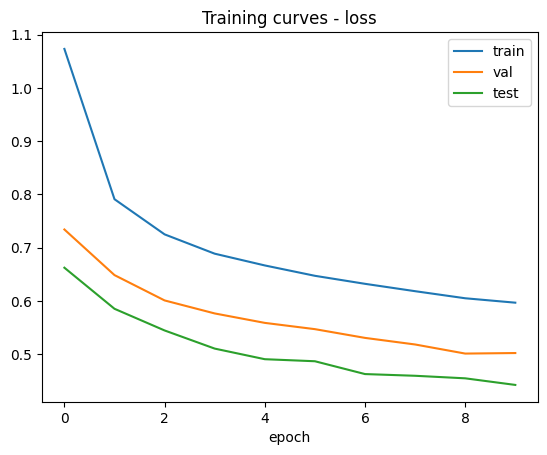

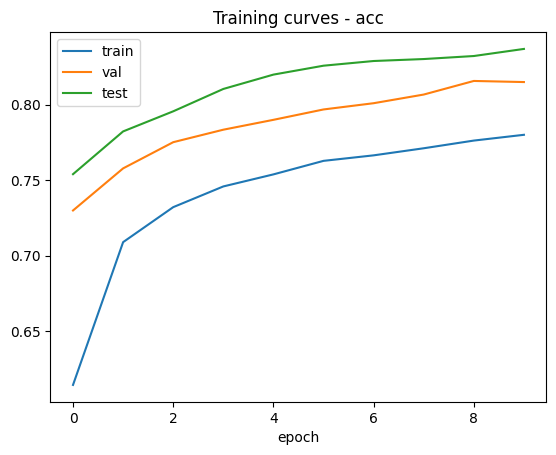

In [ ]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

### Plotting the Confusion Matrix

#### **Code: `res = plot_cm(model, device, dataloaders, phase='test')`**
- **Purpose**: Evaluates the model's performance on the test dataset by visualizing the confusion matrix, which compares true labels to predicted labels.

#### **Parameters**
- **`model`**: The trained classification model.
- **`device`**: The computation device (e.g., GPU or CPU).
- **`dataloaders`**: Dictionary containing data loaders for training, validation, and test datasets.
- **`phase`**: Specifies which dataset phase to evaluate (default: `'test'`).

#### **Key Features**
- **Confusion Matrix**:
  - A tabular representation of the counts of true vs. predicted labels for each class.
  - Highlights correct classifications (diagonal values) and misclassifications (off-diagonal values).
- **Visualization**:
  - Uses scikit-learn's `metrics.ConfusionMatrixDisplay` to plot the confusion matrix.
  - Adds class labels for clarity.

#### **Output**
- Displays a confusion matrix plot with:
  - **Axes**:
    - X-axis: Predicted class labels.
    - Y-axis: True class labels.
  - **Title**: Indicates it's a confusion matrix with counts.


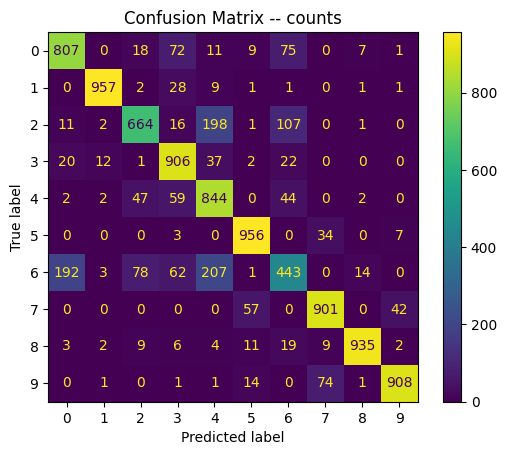

In [ ]:
res = plot_cm(model, device, dataloaders, phase='test')

### Displaying Examples from Each FashionMNIST Class

#### **Code Overview**
This code visualizes one example image for each of the 10 classes in the FashionMNIST dataset.

#### **Key Components**
1. **Class Labels**:
   - **`class_labels`**: A dictionary mapping class indices (0-9) to their corresponding FashionMNIST category (e.g., `0: 'T-shirt/top'`).

2. **Function: `show_class_examples`**:
   - **Purpose**: Loops through the dataset to find and display one example image for each class.
   - **Parameters**:
     - `dataset`: The dataset to sample from (e.g., test set).
     - `class_labels`: A dictionary mapping class indices to human-readable names.
   - **Steps**:
     - Creates a 2x5 grid of subplots to display the images.
     - Tracks which classes have already been displayed using a set (`found_classes`).
     - Loops through the dataset to extract images and labels.
     - Stops once all 10 classes have been displayed.

3. **Visualization**:
   - Each subplot shows an image with its corresponding class name and index as the title.
   - Subplots are organized in a 2x5 grid for clarity.



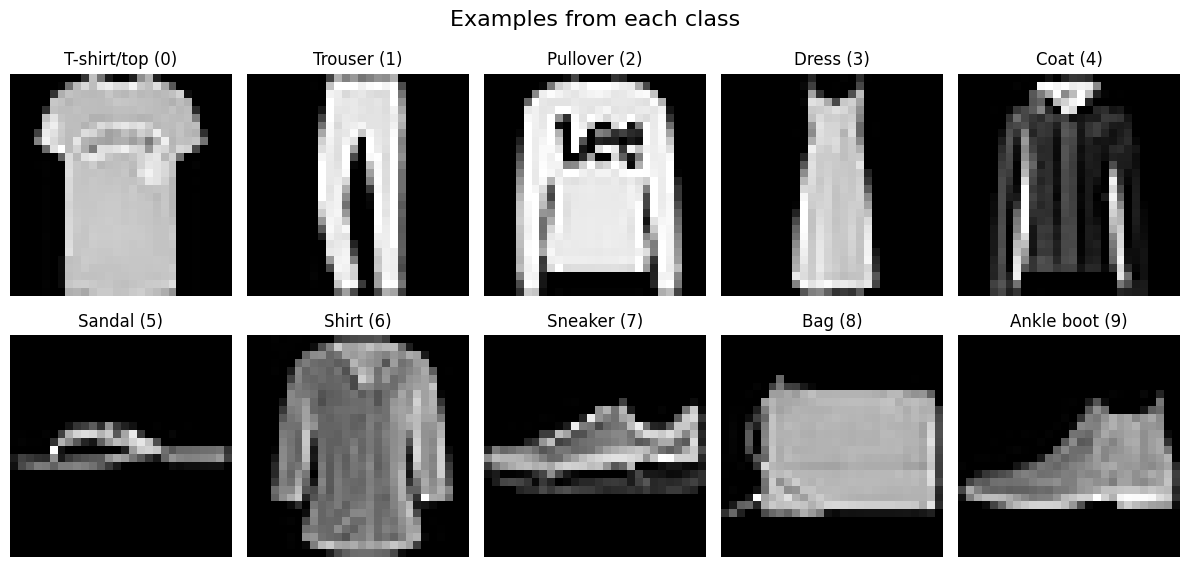

In [ ]:
import matplotlib.pyplot as plt

# Class labels for FashionMNIST
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Function to display one example from each class
def show_class_examples(dataset, class_labels):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle("Examples from each class", fontsize=16)

    # Track if we've found an example for each class
    found_classes = set()

    # Loop through the dataset
    for inputs, labels in dataset:
        for i in range(len(labels)):
            label = labels[i].item()

            # If we haven't already displayed an example of this class
            if label not in found_classes:
                ax = axes[label // 5, label % 5]
                ax.imshow(inputs[i].squeeze(), cmap='gray')
                ax.set_title(f'{class_labels[label]} ({label})')
                ax.axis('off')

                # Mark this class as found
                found_classes.add(label)

            # Stop when we have found all 10 classes
            if len(found_classes) == 10:
                break
        if len(found_classes) == 10:
            break

    plt.tight_layout()
    plt.show()

# Load test set
dataset_test = DataLoader(fashion_mnist_test, batch_size=100, shuffle=False)

# Call the function to display one example from each class
show_class_examples(dataset_test, class_labels)
